In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib

import pywt
from statsmodels.robust import stand_mad

def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

def get_X_data():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

X = get_X_data()

Using TensorFlow backend.


In [2]:
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size
X["HLC"] = (X.high + X.low + X.close) / 3
X["return"] = X.HLC.pct_change()
X["return"] = X["return"].fillna(0)

### Utility Functions

In [3]:
time_series_step=4

def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(raw_time_series, lag)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

In [94]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []


    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
    def on_batch_begin(self, batch, logs={}):
        self.model.reset_states()

### Wavelet Decomposition

In [22]:
# Wavelet Decomposition
level = 9
haar = pywt.Wavelet("haar")
coeffs = pywt.wavedec(X["return"].values, haar, level=9)
recomposed_return = pywt.waverec(coeffs, haar)

# Wavelet De-noising
sigma = stand_mad(coeffs[-1])
uthresh = sigma*np.sqrt(2*np.log(len(X["return"].values)))
denoised = coeffs[:]
denoised[1:] = (pywt.threshold(i, value=uthresh) for i in denoised[1:])
denoised_return = pywt.waverec(denoised, haar)
X["denoised"] = denoised_return[:-1]

diff = denoised_return[:-1] - X["return"].values
correlation = np.corrcoef(denoised_return[:-1], X["return"].values)
print("There are total of {} elements".format(len(denoised_return)))
print("Total absolute difference: {}".format(np.abs(diff).sum()))
print("Correlation between denoised and original: {}".format(correlation[0][1]))

#Divide Data into Train and Test

X_train = X["2012":"2015"]
X_test = X["2016":]
print("Test: {:.2f}%".format(100 * len(X_test)/len(X["2012":])))
print("Train: {:.2f}%".format(100 * len(X_train)/len(X["2012":])))

y = X["return"].shift(-1)
y = y.fillna(0)
y_train = y["2012":"2015"]
y_test  = y["2016":]

del X_train['HLC']
del X_train['open']
del X_train['high'] 
del X_train['low']
del X_train['close']
del X_train['volume']
del X_train['openint']

del X_test["HLC"]
del X_test['open']
del X_test['high'] 
del X_test['low']
del X_test['close']
del X_test['volume']
del X_test['openint']

# Normalize de-noised return
scaler = StandardScaler()
X_train["denoised_scaled"] = scaler.fit_transform(pd.DataFrame(X_train["denoised"].values))
X_test["denoised_scaled"] = scaler.transform(pd.DataFrame(X_test["denoised"].values))

X_train = create_supervised_X(pd.DataFrame(X_train["denoised_scaled"]), time_series_step)
X_test  = create_supervised_X(pd.DataFrame(X_test["denoised_scaled"]), time_series_step)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

batch_size = 15
features = 1

model = Sequential()
model.add(
    LSTM(128, batch_input_shape=(batch_size, time_series_step+1, features), stateful=True, 
         return_sequences=True, 
         activation="relu",
         kernel_regularizer='l1',
          recurrent_regularizer='l1',
          bias_regularizer='l1',
          dropout=0.1,
          recurrent_dropout=0.1
        ÷≥≥≥)≥
)

model.add(
    LSTM(128, stateful=True, 
         return_sequences=True, 
         activation="relu",
         kernel_regularizer='l1',
          recurrent_regularizer='l1',
          bias_regularizer='l1',
          dropout=0.1,
          recurrent_dropout=0.1
        )
)
    
model.add(
    LSTM(32, 
         activation="relu", 
         stateful=True, 
         return_sequences=True,
         kernel_regularizer='l1',
         recurrent_regularizer='l1',
         bias_regularizer='l1',
         dropout=0.1,
         recurrent_dropout=0.1)
)

model.add(LSTM(1))

model.compile(loss="mse", optimizer="adadelta")

There are total of 958636 elements
Total absolute difference: 230.6085907747903
Correlation between denoised and original: 0.9060392654130378
Test: 33.35%
Train: 66.65%


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [23]:
history = LossHistory()
model.fit(X_train.values, 
          y_train, 
          epochs=2, 
          batch_size=batch_size, 
          shuffle=False, 
          validation_data=(X_test.values, y_test),
          callbacks=[history]
)

Train on 333465 samples, validate on 166845 samples
Epoch 1/2
333465/333465 [==============================] - 915s - loss: 3.8337 - val_loss: 4.5103
Epoch 2/2
333465/333465 [==============================] - 900s - loss: 5.2897 - val_loss: 5.8350


In [25]:
predict = model.predict(X_train.values, batch_size=15)

In [26]:
test_predict = model.predict(X_test.values, batch_size=15)

In [35]:
history.losses

[101.03214,
 96.209648,
 94.90728,
 93.845146,
 92.684723,
 92.910255,
 91.06739,
 90.053345,
 89.903465,
 88.060425,
 87.397652,
 86.253265,
 85.017937,
 84.131836,
 94.382568,
 84.863403,
 81.749527,
 81.702477,
 79.921089,
 79.449089,
 79.917084,
 78.565407,
 76.514763,
 75.134636,
 74.621552,
 73.449028,
 72.366943,
 71.741646,
 70.87291,
 75.847122,
 71.019432,
 68.945366,
 67.672745,
 73.252304,
 66.035469,
 65.760971,
 64.105782,
 63.479855,
 64.066444,
 61.677116,
 61.065811,
 60.739727,
 59.290825,
 58.660233,
 60.846786,
 59.980053,
 57.095585,
 57.994316,
 57.154003,
 57.271931,
 55.036884,
 53.503593,
 52.731041,
 51.665897,
 50.598183,
 50.142998,
 49.330143,
 49.703285,
 47.972908,
 51.988964,
 49.114586,
 47.283798,
 45.821083,
 45.064941,
 44.362976,
 43.434113,
 43.024139,
 42.480007,
 48.008041,
 47.541424,
 40.532101,
 39.870235,
 40.505131,
 38.883026,
 45.690254,
 39.180248,
 38.337288,
 38.932281,
 36.338936,
 35.765541,
 35.119068,
 34.405209,
 34.095047,
 33.377

In [53]:
losses = pd.DataFrame(history.losses).reindex()

(44462, 1)

In [57]:
losses.index.values

array([    0,     1,     2, ..., 44459, 44460, 44461])

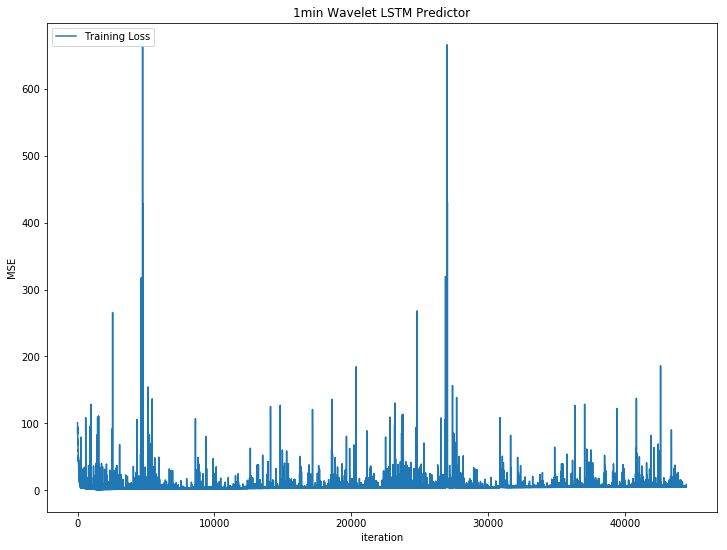

In [81]:
plt.clf()
# summarize history for loss

# plt.plot(SAE_results[0].history['loss'][:size_limit])
# plt.plot(history.history['loss'][:size_limit])
# plt.plot(deep_results[0].history['loss'][:size_limit])
plt.plot(np.array(history.f))
plt.title('1min Wavelet LSTM Predictor')
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.legend(["Training Loss", ], loc='upper left')
plt.show()

In [79]:
np.array(history.losses)

array([ 101.03213501,   96.20964813,   94.90727997, ...,    5.19644594,
          5.19132805,    8.71734428], dtype=float32)